In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import tensorflow as tf
from sklearn.utils import shuffle
from keras import backend as K

2023-12-15 18:11:18.002184: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 18:11:18.028547: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 18:11:18.028579: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 18:11:18.028608: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 18:11:18.034388: I tensorflow/core/platform/cpu_feature_g

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.14.0
Num GPUs Available:  1


### Source:
*[Learning to Pivot with Adversarial Networks](https://arxiv.org/pdf/1611.01046.pdf)* \
arxiv 1611.01046

### Generate Data

As a toy example lets consider the binary classification of 2D data drawn from multivariate gaussians:

$$
\begin{align}
x & \sim \mathcal{N} \left( (0,0), \begin{bmatrix}1 & -0.5\\-0.5 & 1 \end{bmatrix} \right) & \text{when } Y = 0 \\
x|Z=z & \sim \mathcal{N} \left( (1,1+z), \begin{bmatrix}1 & 0\\0 & 1 \end{bmatrix} \right) & \text{when } Y = 1
\end{align}
$$

Where Z is continuous nuisance parameter which represents the uncertainty about the location of the mean and z is a gaussian prior $ z \sim \mathcal{N}(0,1)$.

In [3]:
# Specify total number of points
n_points = 100000

# Generate Background Distribution
bkg = np.random.multivariate_normal([0,0],[[1,-0.5],[-0.5,1]],n_points)
x_bkg = bkg[:,0]
y_bkg = bkg[:,1]

# Generate Signal Distribution with "noise" z
sig_list=[]
z = np.random.normal(0,1,n_points)
for i in range(n_points):
    sig_list.append(np.random.multivariate_normal([1,1+z[i]],[[1,0],[0,1]]))
sig = np.array(sig_list)
x_sig = sig[:,0]
y_sig = sig[:,1]

# Generate labels for z (used for adversary model)
n_bins = 8

z_bins = np.linspace(-3,3,n_bins+1)
z_labels_sig=[]
for i in range(len(z)):
    z_label = np.array([0]*n_bins)
    
    #Underflow
    if z[i] < z_bins[0]:
        z_label[0]=1
        z_labels_sig.append(z_label)
        continue
        
    #Overflow
    if z[i] > z_bins[-1]:
        z_label[-1]=1
        z_labels_sig.append(z_label)
        continue

    #Loop through bins
    for j in range(n_bins):
        if z[i] < z_bins[j+1]:
            z_label[j]=1
            z_labels_sig.append(z_label)
            break
            
z_labels_sig = np.array(z_labels_sig)
z_labels_bkg = np.zeros((n_points,n_bins))

# combine the one-hot z labels and binary sig/bkg label
# last element in label is sig/bkg, others are one hot encoded bins
combined_labels_sig = np.insert(z_labels_sig,n_bins,1,axis=1)
combined_labels_bkg = np.insert(z_labels_bkg,n_bins,0,axis=1)  

X = np.vstack((sig,bkg))
Y = np.vstack((combined_labels_sig,combined_labels_bkg))
              
x_train, y_train = shuffle(X,Y)

### Plot the Signal and Background Distributions

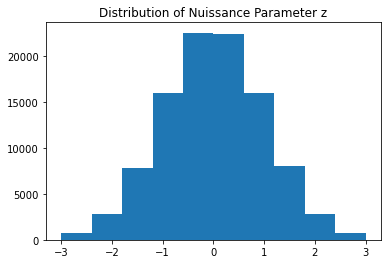

In [4]:
# modify existing Reds colormap with a linearly fading alpha
red = plt.cm.Reds  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

xmin=-3
xmax=4
ymin=-3
ymax=4
#fig, ax = plt.subplots(1,1)
plt.hist2d(x_bkg,y_bkg,bins=100,range=[[xmin, xmax], [ymin, ymax]],cmap="Blues")
plt.hist2d(x_sig,y_sig,bins=100,range=[[xmin, xmax], [ymin, ymax]],cmap=fading_red)
#plt.legend(["bkg","sig"])
plt.title("Signal and Background Distributions")
plt.show()

plt.hist(z,range=(-3,3))
plt.title("Distribution of Nuissance Parameter z")
plt.show()

### Define Entire Model Structure

In [5]:
input_shape = sig.shape[1]

def Entire_Model(input_shape):
    input_layer = tf.keras.Input(shape=(input_shape,),name="input_layer")
    
    ## first we have the classifier part
    dense_cl_hidden1 = tf.keras.layers.Dense(20, activation="relu", 
                                             name="dense_cl_hidden1")(input_layer)
    dense_cl_hidden2 = tf.keras.layers.Dense(20, activation="relu", 
                                             name="dense_cl_hidden2")(dense_cl_hidden1)
    dense_cl_output = tf.keras.layers.Dense(1, activation="sigmoid",
                                            name="dense_cl_output")(dense_cl_hidden2)
    
    ## Next we have the adversarial part
    dense_ad_hidden1 = tf.keras.layers.Dense(20, activation="relu", 
                                             name="dense_ad_hidden1")(dense_cl_output)
    dense_ad_hidden2 = tf.keras.layers.Dense(20, activation="relu", 
                                             name="dense_ad_hidden2")(dense_ad_hidden1)
    dense_ad_output = tf.keras.layers.Dense(n_bins, activation="softmax", 
                                            name="dense_ad_output")(dense_ad_hidden2)
    
    MergeOutput = tf.keras.layers.Concatenate()([ dense_ad_output, dense_cl_output ])

    ANN_Model = tf.keras.Model(inputs=input_layer, outputs =MergeOutput)
    return ANN_Model


model=Entire_Model(input_shape)
model._name="Entire_ANN_Model"
model.summary()

Model: "Entire_ANN_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 2)]                  0         []                            
                                                                                                  
 dense_cl_hidden1 (Dense)    (None, 20)                   60        ['input_layer[0][0]']         
                                                                                                  
 dense_cl_hidden2 (Dense)    (None, 20)                   420       ['dense_cl_hidden1[0][0]']    
                                                                                                  
 dense_cl_output (Dense)     (None, 1)                    21        ['dense_cl_hidden2[0][0]']    
                                                                                   

2023-12-15 18:11:22.621495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22396 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


### Define Custom Loss Functions

In [6]:
def custom_loss_cl_only(y_true, y_pred):
    cl_loss = tf.keras.losses.binary_crossentropy(y_true[:,-1],y_pred[:,-1])
    return cl_loss

def custom_loss_ad_only(y_true, y_pred):
    ANN_loss = tf.keras.losses.categorical_crossentropy(y_true[:,0:-1], y_pred[:,0:-1])
    return ANN_loss

def custom_loss_total(lamb):
    
    def lossFunction(y_true,y_pred):
        cl_loss = tf.keras.losses.binary_crossentropy(y_true[:,-1],y_pred[:,-1])
        ANN_loss = tf.keras.losses.categorical_crossentropy(y_true[:,0:-1], y_pred[:,0:-1])
        return cl_loss - lamb * ANN_loss
    
    return lossFunction


In [7]:
print("*******************************************")
print("***\tPretrain For Classification\t***")
print("***\t(Fix Adversarial Parameters)\t***")
print("*******************************************")

model.compile(loss=custom_loss_cl_only, 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              #metrics=[tf.keras.metrics.BinaryAccuracy(name='acc')]
             )

## when pre-training classifer, adversary parameters need to be frozen
for il in range(len(model.layers)):
    if "ad" in model.layers[il].name:
        model.layers[il].trainable = False
    if "cl" in model.layers[il].name:
        model.layers[il].trainable = True

history = model.fit(x_train,y_train,batch_size=64,epochs=10,validation_split=0.15)

*******************************************
***	Pretrain For Classification	***
***	(Fix Adversarial Parameters)	***
*******************************************
Epoch 1/10


2023-12-15 18:11:24.757254: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd87c1481a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-15 18:11:24.757279: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-15 18:11:24.760328: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-15 18:11:24.779069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-12-15 18:11:24.832929: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2657/2657 [==============================] - 10s 3ms/step - loss: 0.6604 - val_loss: 0.6226
Epoch 2/10
2657/2657 [==============================] - 7s 3ms/step - loss: 0.5942 - val_loss: 0.5678
Epoch 3/10
2657/2657 [==============================] - 7s 3ms/step - loss: 0.5486 - val_loss: 0.5289
Epoch 4/10
2657/2657 [==============================] - 7s 3ms/step - loss: 0.5163 - val_loss: 0.5017
Epoch 5/10
2657/2657 [==============================] - 7s 3ms/step - loss: 0.4948 - val_loss: 0.4843
Epoch 6/10
2657/2657 [==============================] - 7s 3ms/step - loss: 0.4816 - val_loss: 0.4737
Epoch 7/10
2657/2657 [==============================] - 7s 3ms/step - loss: 0.4733 - val_loss: 0.4669
Epoch 8/10
2657/2657 [==============================] - 7s 3ms/step - loss: 0.4678 - val_loss: 0.4623
Epoch 9/10
2657/2657 [==============================] - 7s 3ms/step - loss: 0.4639 - val_loss: 0.4591
Epoch 10/10
2657/2657 [==============================] - 7s 3ms/step - loss: 0.4611 - val_lo

In [8]:
def display_learning_curves(history):
    fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    #ax2.plot(history.history["acc"])
    #ax2.plot(history.history["val_acc"])
    #ax2.legend(["train", "test"], loc="upper right")
    #ax2.set_xlabel("Epochs")
    #ax2.set_ylabel("Accuracy")
    plt.show()


In [9]:
display_learning_curves(history)

get_cl_output = K.function([model.get_layer(name="input_layer").input],
                           [model.get_layer(name="dense_cl_output").output])

y_pred = get_cl_output([x_train])[0]

acc_initial = tf.keras.metrics.binary_accuracy(y_train[:,-1], y_pred.flatten(), threshold=0.5).numpy()
print("Binary Accuracy: ", acc_initial)

Binary Accuracy:  0.77821


In [10]:
test_points=1000
test_list=[[],[],[]]
z_test = [-1,0,1]
for i in range(len(z_test)):
    for j in range(test_points):
        test_list[i].append(np.random.multivariate_normal([1,1+z_test[i]],[[1,0],[0,1]]))

test0 = np.array(test_list[0])
test1 = np.array(test_list[1])
test2 = np.array(test_list[2])

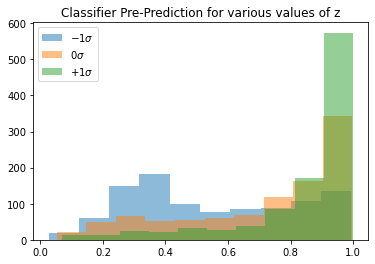

In [11]:
get_cl_output = K.function([model.get_layer(name="input_layer").input],
                           [model.get_layer(name="dense_cl_output").output])

cl_output0 = get_cl_output([test0])[0]
cl_output1 = get_cl_output([test1])[0]
cl_output2 = get_cl_output([test2])[0]

plt.hist(cl_output0,alpha=0.5,label=r'$-1 \sigma$')
plt.hist(cl_output1,alpha=0.5,label=r'$0 \sigma$')
plt.hist(cl_output2,alpha=0.5,label=r'$+1 \sigma$')
plt.title("Classifier Pre-Prediction for various values of z")
plt.legend()
plt.show()

### Run Algorithm 1

Use the algorithm described in the paper to train the Classifier against an Adversary.

In [12]:
epochs = 15
lamb = 100

combined_loss=[]
adversary_loss=[]
cl_only_loss=[]

"""
lr = []
for i in range(epochs):
    if epochs<=5:
        lr.append(0.001)
    else:
        lr.append(0.0001)
"""

for e in range(epochs):
    print("*******************************************")
    print("***\t\t(",e+1,"/",epochs,")\t\t***")
    print("*******************************************")  
    
    print("Training Adversarial Model...")
    print("\t(with CCE loss function)")

    for il in range(len(model.layers)):
        if "ad" in model.layers[il].name:
            model.layers[il].trainable = True
        if "cl" in model.layers[il].name:
            model.layers[il].trainable = False

    model.compile(loss=custom_loss_ad_only,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                 )
        
    history = model.fit(x_train,
                        y_train,
                        batch_size=128,
                        epochs=5,
                        verbose=0,
                       )

    ANN_loss = np.array(history.history["loss"])
    adversary_loss.append(ANN_loss[-1])
    
    print("Training Classifier Model...")
    print("\t(with combined loss function)")
    
    for il in range(len(model.layers)):
        if "ad" in model.layers[il].name:
            model.layers[il].trainable = False
        if "cl" in model.layers[il].name:
            model.layers[il].trainable = True
            
    model.compile(loss=custom_loss_total(lamb),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                 )
    
    history = model.fit(x_train,
                        y_train,
                        batch_size=128,
                        epochs=1,
                        verbose=0,
                       )

    combined_loss.append(history.history["loss"])

    get_cl_output = K.function([model.get_layer(name="input_layer").input],
                           [model.get_layer(name="dense_cl_output").output])
    y_pred = get_cl_output([x_train])[0]
    cl_loss = tf.keras.losses.binary_crossentropy(y_train[:,-1],y_pred.flatten())
    cl_only_loss.append(cl_loss)
    
## release all the parameters
for il in range(len(model.layers)):
    if "ad" in model.layers[il].name:
        model.layers[il].trainable = True
    if "cl" in model.layers[il].name:
        model.layers[il].trainable = True

print("DONE")

*******************************************
***		( 1 / 15 )		***
*******************************************
Training Adversarial Model...
	(with CCE loss function)
Training Classifier Model...
	(with combined loss function)
*******************************************
***		( 2 / 15 )		***
*******************************************
Training Adversarial Model...
	(with CCE loss function)
Training Classifier Model...
	(with combined loss function)
*******************************************
***		( 3 / 15 )		***
*******************************************
Training Adversarial Model...
	(with CCE loss function)
Training Classifier Model...
	(with combined loss function)
*******************************************
***		( 4 / 15 )		***
*******************************************
Training Adversarial Model...
	(with CCE loss function)
Training Classifier Model...
	(with combined loss function)
*******************************************
***		( 5 / 15 )		***
***********************************

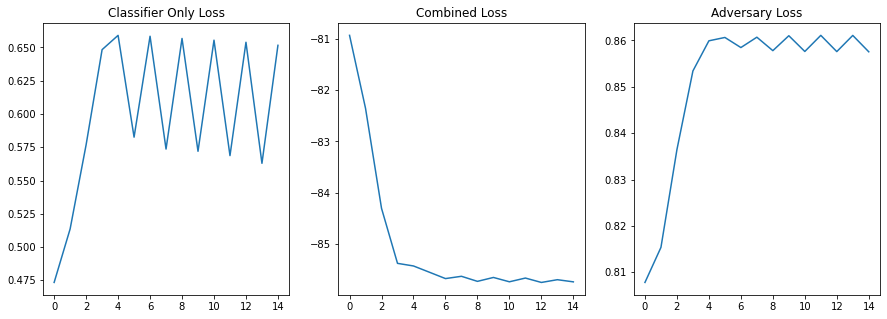

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(cl_only_loss)
ax1.set_title('Classifier Only Loss')
ax2.plot(combined_loss)
ax2.set_title('Combined Loss')
ax3.plot(adversary_loss)
ax3.set_title('Adversary Loss')
plt.show()

plt.figure()
max_cl = np.max(cl_only_loss)
max_ad = np.max(adversary_loss)
plt.plot(cl_only_loss/max_cl)
plt.plot(adversary_loss/max_ad)
plt.show()

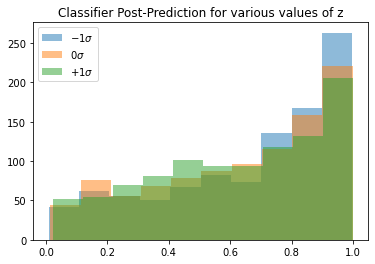

Binary Accuracy Final:  0.67545
Binary Accuracy Initial:  0.77821


In [14]:
get_cl_output = K.function([model.get_layer(name="input_layer").input],
                           [model.get_layer(name="dense_cl_output").output])

cl_output0 = get_cl_output([test0])[0]
cl_output1 = get_cl_output([test1])[0]
cl_output2 = get_cl_output([test2])[0]

plt.hist(cl_output0,alpha=0.5,label=r'$-1 \sigma$')
plt.hist(cl_output1,alpha=0.5,label=r'$0 \sigma$')
plt.hist(cl_output2,alpha=0.5,label=r'$+1 \sigma$')
plt.legend()
plt.title("Classifier Post-Prediction for various values of z")
plt.show()

y_pred = get_cl_output([x_train])[0]

acc_final = tf.keras.metrics.binary_accuracy(y_train[:,-1], y_pred.flatten(), threshold=0.5).numpy()
print("Binary Accuracy Final: ", acc_final)
print("Binary Accuracy Initial: ", acc_initial)

Even though the accuracy of the model decreased, the output of the classifier is agnostic w.r.t the nuisance paramter z.